# Advanced Lane Detection

This implementation tries to find the current driving lane of a car. It is based on the technicts taught in the online course ["Self Driving Car Engineer" from Udacity](https://udacity.com/course/self-driving-car-engineer-nanodegree--nd013) and on the paper ["Real time Detection of Lane Markers in Urban Streets" by Mohamed Aly](http://www.mohamedaly.info/research/lane-detection)


## Image Distortion and Top View

This helps to remove perspective effects in an images. Lines that are actually parallel, converge at the horizon in an images captured by a camera. The calculation of a top view gets rid of this effect, so that lanes appear parallel. 

In [6]:

import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# See jupyter notebook Camera_Calibration.jpynb
dist_pickle = pickle.load( open( "camera_cal_data/camera_calibration_data.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plt_img_width = 10
plt_img_height = 8

def top_view(img, mtx, dist):
    # undistort image
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # top left, top right, bottom right, bottom left
    corners = [[603,440], [673,440], [1017, 660], [229,660]]
    
    img_height, img_width, img_depth = img.shape
    
    margin_horz = 200
    margin_vert = 0
   
    src_rect = np.float32(
        [corners[0], 
        corners[1],
        corners[2],
        corners[3]])

    dest_rect= np.float32([
        [margin_horz,             margin_vert],
        [img_width - margin_horz, margin_vert],
        [img_width - margin_horz, img_height - margin_vert],
        [margin_horz,             img_height - margin_vert]])

    M = cv2.getPerspectiveTransform(src_rect, dest_rect)
    warped = cv2.warpPerspective(img_undistorted, M, (img_width, img_height))
    return warped, M
                                 


This is an orignal image from camera

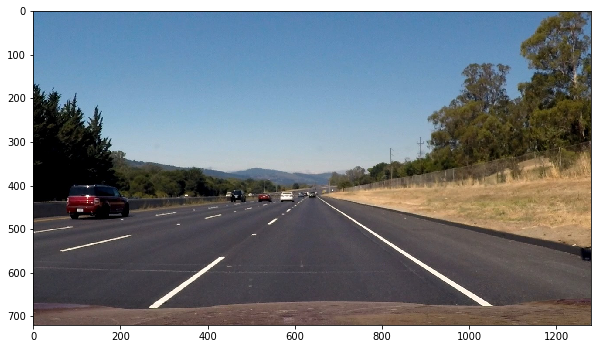

In [7]:
# read a distorted image
distorted_image = mpimg.imread('test_images/straight_lines2.jpg')

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(distorted_image)


And this is the undistorted top view

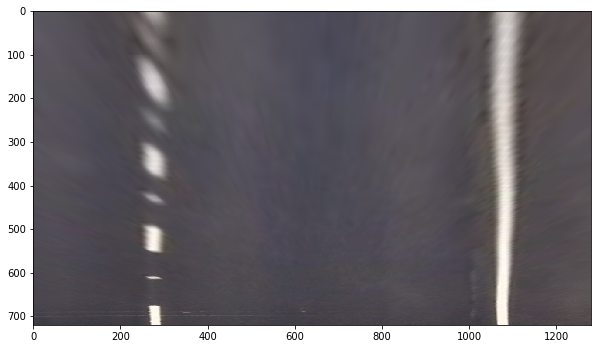

In [8]:
# read a distorted image
topview_image, M = top_view(distorted_image, mtx, dist) 

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(topview_image)

# image dimensions
topview_image_height, topview_image_width, topview_image_depth = topview_image.shape 

This show the undistorted top view of all test images

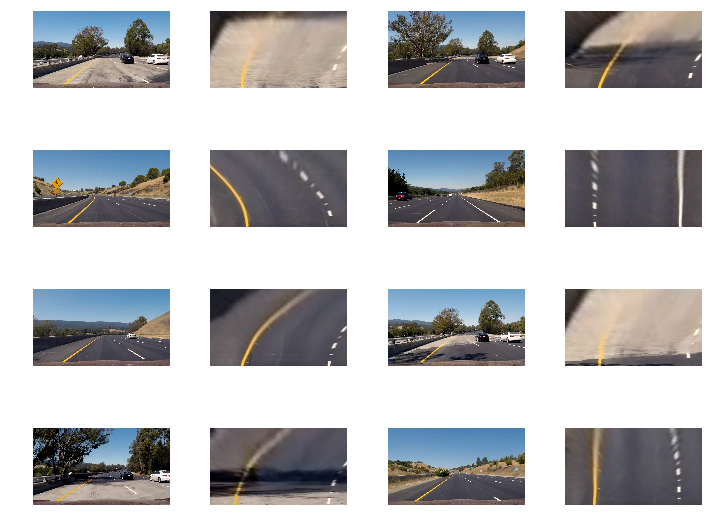

In [9]:
test_images_file_filter = 'test_images/*.jpg'
test_images_file_file_names = glob.glob(test_images_file_filter)
undistorted_top_views = []

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(plt_img_width, plt_img_height))
axs = axs.ravel()

for index, distorted_image_file_name in zip(range(len(test_images_file_file_names)), test_images_file_file_names):
    distorted_image = mpimg.imread(distorted_image_file_name)
    
    topview_image, M = top_view(distorted_image, mtx, dist)
    undistorted_top_views.append(topview_image)
    
    axs[index*2].imshow(distorted_image)
    axs[index*2].set_axis_off()
    axs[index*2+1].imshow(topview_image)
    axs[index*2+1].set_axis_off()
    
plt.tight_layout()


## Evaluation of color channel

Lane dividers have two major color properties, saturation and lightness, to contrast with the road. We may take advantages of this by transforming the image to the HLS color space.

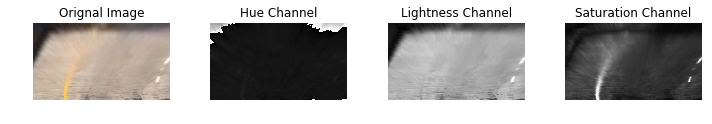

In [10]:
def show_hls_color_channels(channel_eval_image):
    hls_image = cv2.cvtColor(channel_eval_image, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(plt_img_width, plt_img_height))
    axs[0].set_title("Orignal Image")
    axs[0].imshow(channel_eval_image)
    axs[0].set_axis_off()
    axs[1].set_title("Hue Channel")
    axs[1].imshow(h_channel / 100.0, cmap='gray')
    axs[1].set_axis_off()
    axs[2].set_title("Lightness Channel")
    axs[2].imshow(l_channel, cmap='gray')
    axs[2].set_axis_off()
    axs[3].set_title("Saturation Channel")
    axs[3].imshow(s_channel, cmap='gray')
    axs[3].set_axis_off()
    plt.tight_layout()
    
show_hls_color_channels(undistorted_top_views[0])



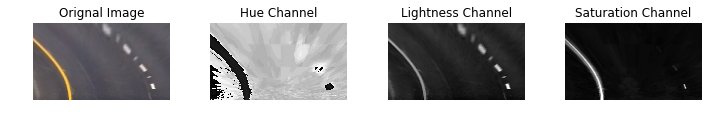

In [11]:
show_hls_color_channels(undistorted_top_views[2])

We can see that the saturation channel is suitable to extract yellow lines, whereas the lightness channel seems to extract white markes. 

## Marker extraction

Different to the approach from Udacity, I use gaussian spatial filters to detect vertical lines, as described in Mohamed Aly's paper on the lighness channel and on the saturation channel. The respons
e of this filter is then thresholded and merged.

In [12]:
# calucate the derivative of a gaussian
def get_derivative_gaussian(w, sigma):
    d = np.zeros(w*2+1)    
    
    for x in range(-w,w+1):
        i = x + w
        d[i] = (1.0/sigma**2) * np.exp((-(x**2)) / (2 * sigma**2)) * (1 - (x**2 / sigma**2))        
    
    return d

# calculate a gaussian
def get_gaussian(w, sigma):
    g = np.zeros(w*2+1)
    
    for x in range(-w,w+1):
        i = x + w
        g[i] = np.exp(-((x**2)/(2*sigma**2)))
    
    return g

# combine the derivative of a gaussian and a gaussian to a kernel
def get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height):
    derivative_gaussian = np.mat(get_derivative_gaussian(kernel_width,sigma_width))
    gaussian = np.mat(get_gaussian(kernel_height, sigma_height))
    kernel = gaussian.T * derivative_gaussian
    return kernel


### Gaussian Curves


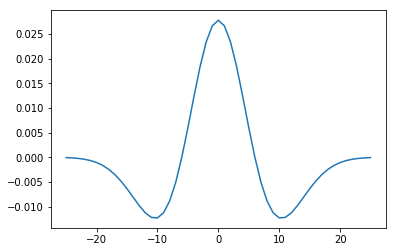

In [13]:
kernel_width = 25
sigma_width = 6
t1 = np.arange(-kernel_width, kernel_width+1)
plt.plot(t1, get_derivative_gaussian(kernel_width,sigma_width))

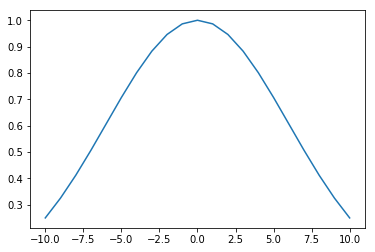

In [14]:
kernel_height = 10
sigma_height = 6
t2 = np.arange(-kernel_height, kernel_height+1)
plt.plot(t2, get_gaussian(kernel_height,sigma_height))

### Spatial Filter Kernel


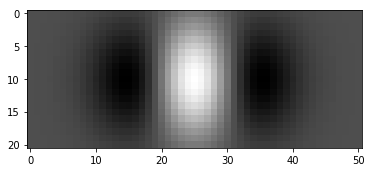

In [15]:
spatial_filter = get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height)
cv2.normalize(spatial_filter,spatial_filter)

plt.imshow(spatial_filter, cmap='gray')

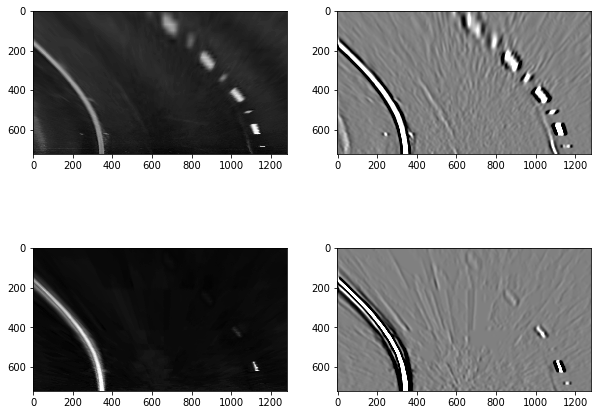

In [16]:
def filter_image(image, kernel):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]

    return cv2.filter2D(l_channel, 1, kernel), cv2.filter2D(s_channel, 1, kernel) 

image_to_filter = undistorted_top_views[2]
filtered_l_channel, filtered_s_channel = filter_image(image_to_filter,spatial_filter)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(plt_img_width, plt_img_height))
axs[0,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,1], cmap='gray')
axs[0,1].imshow(filtered_l_channel, cmap='gray')
axs[1,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')
axs[1,1].imshow(filtered_s_channel, cmap='gray')


### Thresholded images


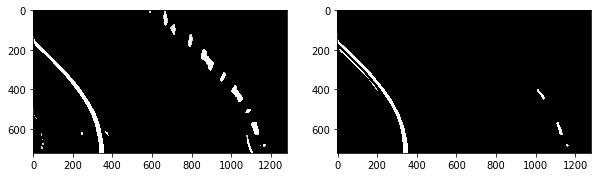

In [17]:
def threshold(image):
    normalized = cv2.normalize(
        image, 0,255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    _, normalized = cv2.threshold(normalized,200.0,255.0,cv2.THRESH_TOZERO)
    return normalized

normalized_filtered_l_channel = threshold(filtered_l_channel)
normalized_filtered_s_channel = threshold(filtered_s_channel)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(plt_img_width, plt_img_height))
axs[0].imshow(normalized_filtered_l_channel, cmap='gray')
axs[1].imshow(normalized_filtered_s_channel, cmap='gray')


### Merged Image

The lanes stand out now clearly. Both images will be merged in next step by taking the maximum values of each image.

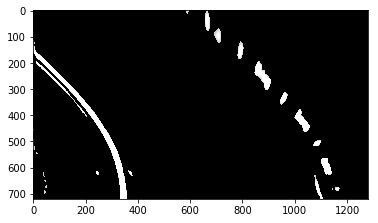

In [18]:
processed_image = np.maximum(normalized_filtered_l_channel, normalized_filtered_s_channel)
plt.imshow(processed_image, cmap='gray')

### Find Lanes

The bottom part of the filtered and thresholded image is used as starting point to find lanes. A summation of the columns and smoothing of that part will show prominent peaks. This is where we start to extract lanes. 

In [56]:
def bottom_smoothed_histogram(image):
    height = image.shape[0]
    bottom = image[height - height//3:, :]
    histogram = np.sum(bottom, axis=0)
    
    window_width = 150
    window = np.ones(window_width)
    conv_signal = np.convolve(window, histogram)
    
    return conv_signal

# Create histogram of image binary activations
lane_histogram = bottom_smoothed_histogram(processed_image)

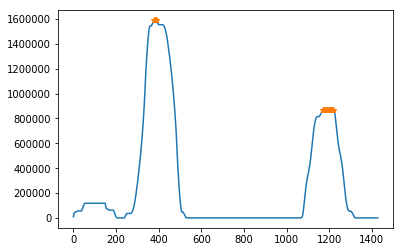

In [57]:
from skimage.feature import peak_local_max

# find the peaks in the histogram
histogram_peak_idx = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
histogram_peak_values =  lane_histogram[histogram_peak_idx]

# Visualize the resulting histogram and show the peaks
fig, ax = plt.subplots()
ax.plot(lane_histogram)
ax.plot(histogram_peak_idx,histogram_peak_values, '*')

